# LIBRARY IMPORTS
This section imports all required libraries for the complete analysis pipeline.
Run this cell first before executing any individual analysis scripts.

Libraries Used:
  - pandas: Data manipulation and analysis
  - numpy: Numerical computations and array operations
  - matplotlib.pyplot: Visualization and plotting
  - matplotlib.patches: Custom shapes for visualizations (strike zone, etc.)
  - scipy.stats: Statistical functions (gaussian_kde for density estimation)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
from scipy.stats import gaussian_kde

print("All libraries loaded successfully!")
print("=" * 80)

# PITCHER PERFORMANCE SUMMARY TABLE

Purpose: Generate comprehensive pitcher-level statistics for all pitchers across
         both games, including effectiveness metrics, stuff quality indicators,
         and arsenal composition.

Output: Table 2 in the analysis document - "Pitcher Performance Summary"
        Also exports 'pitcher_summary_table.csv'

Key Metrics Calculated:
  - Strike%, Whiff%, Contact% (effectiveness)
  - Avg/Max Velocity, Avg Spin Rate (stuff quality)
  - Primary and Secondary pitch types with usage rates

In [1]:
# Load data
df = pd.read_csv('AnalyticsQuestionnairePitchData.csv')
df.columns = df.columns.str.strip()

# Define helper function to calculate strike rate
def calculate_strike_rate(pitcher_data):
    strike_calls = ['called_strike', 'swinging_strike', 'foul', 'foul_tip',
                    'strikeout', 'foul_bunt', 'swinging_strike_blocked']
    strikes = pitcher_data[pitcher_data['PitchCall'].isin(strike_calls)].shape[0]
    return (strikes / len(pitcher_data) * 100) if len(pitcher_data) > 0 else 0

# Define helper function to calculate whiff rate
def calculate_whiff_rate(pitcher_data):
    swing_calls = ['swinging_strike', 'foul', 'foul_tip', 'strikeout',
                   'foul_bunt', 'swinging_strike_blocked', 'field_out',
                   'single', 'double', 'triple', 'home_run', 'field_error',
                   'sac_bunt', 'force_out', 'grounded_into_double_play']
    swings = pitcher_data[pitcher_data['PitchCall'].isin(swing_calls)].shape[0]

    whiff_calls = ['swinging_strike', 'strikeout', 'swinging_strike_blocked']
    whiffs = pitcher_data[pitcher_data['PitchCall'].isin(whiff_calls)].shape[0]

    return (whiffs / swings * 100) if swings > 0 else 0

# Define helper function to calculate contact rate
def calculate_contact_rate(pitcher_data):
    swing_calls = ['swinging_strike', 'foul', 'foul_tip', 'strikeout',
                   'foul_bunt', 'swinging_strike_blocked', 'field_out',
                   'single', 'double', 'triple', 'home_run', 'field_error',
                   'sac_bunt', 'force_out', 'grounded_into_double_play']
    swings = pitcher_data[pitcher_data['PitchCall'].isin(swing_calls)].shape[0]

    contact_calls = ['foul', 'foul_tip', 'foul_bunt', 'field_out',
                     'single', 'double', 'triple', 'home_run', 'field_error',
                     'sac_bunt', 'force_out', 'grounded_into_double_play']
    contact = pitcher_data[pitcher_data['PitchCall'].isin(contact_calls)].shape[0]

    return (contact / swings * 100) if swings > 0 else 0

# Build pitcher summary
pitcher_summary = []

for game in [1, 2]:
    game_data = df[df['GamePk'] == game]

    for pitcher_id in game_data['PitcherId'].unique():
        pitcher_data = game_data[game_data['PitcherId'] == pitcher_id]

        # Basic stats
        total_pitches = len(pitcher_data)
        strike_rate = calculate_strike_rate(pitcher_data)
        whiff_rate = calculate_whiff_rate(pitcher_data)
        contact_rate = calculate_contact_rate(pitcher_data)

        # Velocity and spin
        avg_velo = pitcher_data['ReleaseSpeed'].mean()
        max_velo = pitcher_data['ReleaseSpeed'].max()
        avg_spin = pitcher_data['ReleaseSpinRate'].mean()

        # Pitch type distribution
        pitch_counts = pitcher_data['PitchType'].value_counts()
        primary_pitch = pitch_counts.index[0] if len(pitch_counts) > 0 else 'N/A'
        primary_pct = (pitch_counts.iloc[0] / total_pitches * 100) if len(pitch_counts) > 0 else 0

        secondary_pitch = pitch_counts.index[1] if len(pitch_counts) > 1 else 'N/A'
        secondary_pct = (pitch_counts.iloc[1] / total_pitches * 100) if len(pitch_counts) > 1 else 0

        pitcher_summary.append({
            'Pitcher ID': int(pitcher_id),
            'Game': game,
            'Pitches': total_pitches,
            'Strike%': f"{strike_rate:.1f}%",
            'Whiff%': f"{whiff_rate:.1f}%",
            'Contact%': f"{contact_rate:.1f}%",
            'Avg Velo': f"{avg_velo:.1f}" if not np.isnan(avg_velo) else 'N/A',
            'Max Velo': f"{max_velo:.1f}" if not np.isnan(max_velo) else 'N/A',
            'Avg Spin': f"{avg_spin:.0f}" if not np.isnan(avg_spin) else 'N/A',
            'Primary Pitch': f"{primary_pitch} ({primary_pct:.0f}%)",
            'Secondary Pitch': f"{secondary_pitch} ({secondary_pct:.0f}%)"
        })

# Create DataFrame and sort by game and pitch count
summary_df = pd.DataFrame(pitcher_summary)
summary_df = summary_df.sort_values(['Game', 'Pitches'], ascending=[True, False])

# Display the table
print("=" * 120)
print("MASTER PITCHER SUMMARY TABLE")
print("=" * 120)
print(summary_df.to_string(index=False))
print("=" * 120)

# Save to CSV for easy viewing
summary_df.to_csv('pitcher_summary_table.csv', index=False)
print("\nTable saved to 'pitcher_summary_table.csv'")

MASTER PITCHER SUMMARY TABLE
 Pitcher ID  Game  Pitches Strike% Whiff% Contact% Avg Velo Max Velo Avg Spin Primary Pitch Secondary Pitch
          1     1      105   51.4%  22.2%    77.8%     89.1     97.8     2275      FF (39%)        CH (18%)
         11     1       99   44.4%  19.6%    80.4%     88.5     95.8     2295      CU (30%)        FF (23%)
          5     1       29   37.9%  23.1%    76.9%     88.5     96.9     2504      SL (48%)        CU (28%)
         12     1       20   45.0%  36.4%    63.6%     93.2    100.7     2030      CH (45%)        FF (30%)
          3     1       18   38.9%  25.0%    75.0%     92.9     97.6     2458      FC (67%)        SL (11%)
         14     1       16   18.8%   0.0%   100.0%     91.5     95.7     2331      FF (75%)        SL (12%)
         13     1       15   33.3%  28.6%    71.4%     91.7     95.9     2402      FF (60%)        SL (40%)
          4     1       14   21.4%   0.0%   100.0%     89.1     94.5     1932      FF (29%)        FC (29%)

# PITCH ARSENAL COMPOSITION VISUALIZATION

Purpose: Create a stacked bar chart showing pitch type distribution for each
         pitcher who threw 20+ pitches, revealing arsenal diversity and
         strategic pitch selection differences between games.

Output: Figure 1 in the analysis document - "Pitch Arsenal Breakdown by Pitcher"
        Exports 'pitch_arsenal_breakdown.png'

Key Features:
  - Filters for pitchers with 20+ pitches to avoid clutter
  - Color-coded pitch types (FF, SL, CU, CH, SI, FC, KC)
  - Separated by game with visual divider
  - Sorted by game and workload (pitch count)

Chart saved as 'pitch_arsenal_breakdown.png'

PITCH ARSENAL BREAKDOWN SUMMARY
Showing pitchers with 20+ pitches thrown
Total pitchers displayed: 7

Pitch Type Legend:
  FF = Four-Seam Fastball
  SL = Slider
  CU = Curveball
  CH = Changeup
  SI = Sinker
  FC = Cutter
  KC = Knuckle Curve


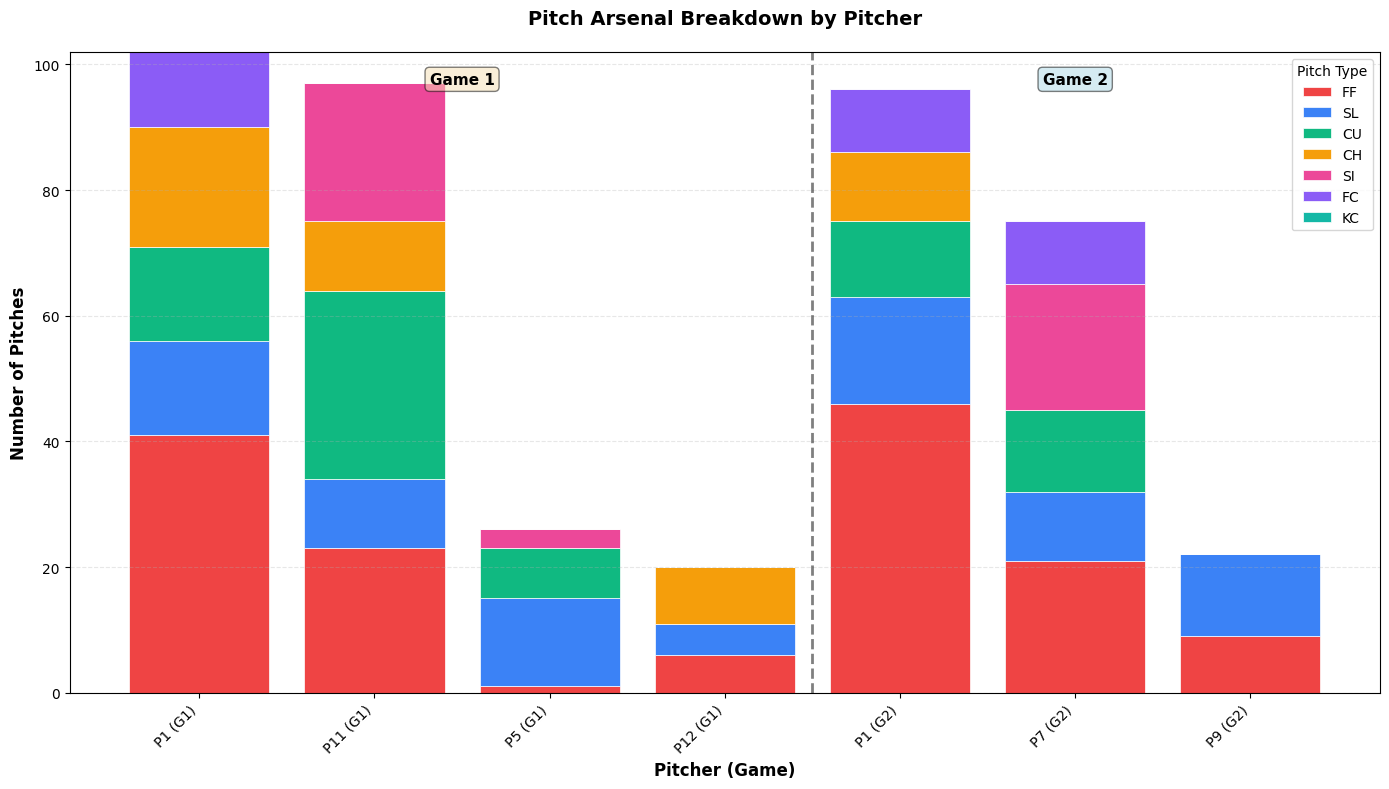

In [2]:
# Load data
df = pd.read_csv('AnalyticsQuestionnairePitchData.csv')
df.columns = df.columns.str.strip()

# Get pitchers with at least 20 pitches (to avoid clutter)
pitcher_pitch_counts = df.groupby(['GamePk', 'PitcherId']).size().reset_index(name='TotalPitches')
significant_pitchers = pitcher_pitch_counts[pitcher_pitch_counts['TotalPitches'] >= 20]

# Prepare data for stacked bar chart
arsenal_data = []

for _, row in significant_pitchers.iterrows():
    game = row['GamePk']
    pitcher_id = row['PitcherId']

    pitcher_data = df[(df['GamePk'] == game) & (df['PitcherId'] == pitcher_id)]
    pitch_counts = pitcher_data['PitchType'].value_counts()

    arsenal_data.append({
        'Pitcher': f"P{int(pitcher_id)} (G{game})",
        'Game': game,
        'PitcherId': pitcher_id,
        'TotalPitches': len(pitcher_data),
        **{pitch_type: pitch_counts.get(pitch_type, 0) for pitch_type in ['FF', 'SL', 'CU', 'CH', 'SI', 'FC', 'KC']}
    })

arsenal_df = pd.DataFrame(arsenal_data)
arsenal_df = arsenal_df.sort_values(['Game', 'TotalPitches'], ascending=[True, False])

# Create the stacked bar chart
pitch_types = ['FF', 'SL', 'CU', 'CH', 'SI', 'FC', 'KC']
colors = {
    'FF': '#ef4444',  # Red - Fastball
    'SL': '#3b82f6',  # Blue - Slider
    'CU': '#10b981',  # Green - Curveball
    'CH': '#f59e0b',  # Orange - Changeup
    'SI': '#ec4899',  # Pink - Sinker
    'FC': '#8b5cf6',  # Purple - Cutter
    'KC': '#14b8a6'   # Teal - Knuckle Curve
}

fig, ax = plt.subplots(figsize=(14, 8))

# Create stacked bars
bottom = np.zeros(len(arsenal_df))

for pitch_type in pitch_types:
    if pitch_type in arsenal_df.columns:
        values = arsenal_df[pitch_type].values
        ax.bar(arsenal_df['Pitcher'], values, bottom=bottom,
               label=pitch_type, color=colors[pitch_type], edgecolor='white', linewidth=0.5)
        bottom += values

# Customize the chart
ax.set_xlabel('Pitcher (Game)', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Pitches', fontsize=12, fontweight='bold')
ax.set_title('Pitch Arsenal Breakdown by Pitcher', fontsize=14, fontweight='bold', pad=20)
ax.legend(title='Pitch Type', loc='upper right', fontsize=10)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha='right')

# Add a vertical line to separate games
game1_count = len(arsenal_df[arsenal_df['Game'] == 1])
if game1_count > 0 and game1_count < len(arsenal_df):
    ax.axvline(x=game1_count - 0.5, color='black', linestyle='--', linewidth=2, alpha=0.5)
    ax.text(game1_count/2 - 0.5, ax.get_ylim()[1] * 0.95, 'Game 1',
            ha='center', fontsize=11, fontweight='bold', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    ax.text(game1_count + (len(arsenal_df) - game1_count)/2 - 0.5, ax.get_ylim()[1] * 0.95, 'Game 2',
            ha='center', fontsize=11, fontweight='bold', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.tight_layout()
plt.savefig('pitch_arsenal_breakdown.png', dpi=300, bbox_inches='tight')
print("Chart saved as 'pitch_arsenal_breakdown.png'")

# Print summary
print("\n" + "=" * 80)
print("PITCH ARSENAL BREAKDOWN SUMMARY")
print("=" * 80)
print(f"Showing pitchers with 20+ pitches thrown")
print(f"Total pitchers displayed: {len(arsenal_df)}")
print("\nPitch Type Legend:")
print("  FF = Four-Seam Fastball")
print("  SL = Slider")
print("  CU = Curveball")
print("  CH = Changeup")
print("  SI = Sinker")
print("  FC = Cutter")
print("  KC = Knuckle Curve")
print("=" * 80)

plt.show()

# STRIKE ZONE COMMAND HEAT MAPS

Purpose: Visualize pitch location patterns for the top two pitchers from each
         game, revealing command tendencies and zone targeting strategies.
         Heat maps show concentration areas from the catcher's perspective.

Output: Figure 2 in the analysis document - "Strike Zone Command - Top Pitchers"
        Exports 'strike_zone_heatmaps.png'

Key Features:
  - 2x2 grid showing top 2 pitchers per game (by pitch count)
  - Heat map intensity shows pitch concentration (warmer = more pitches)
  - Strike zone overlay with 9-zone grid for reference
  - Home plate representation at bottom for orientation
  - Catcher's perspective (RHH batter boxes on right)

Heat maps saved as 'strike_zone_heatmaps.png'

STRIKE ZONE HEAT MAP SUMMARY
Showing pitch location patterns for top pitchers by workload

Pitchers analyzed:
  1. Pitcher 1 (Game 1): 105 pitches
  2. Pitcher 11 (Game 1): 99 pitches
  3. Pitcher 1 (Game 2): 96 pitches
  4. Pitcher 7 (Game 2): 77 pitches

Interpretation:
  - Warmer colors (red/orange) = higher pitch concentration
  - Blue dashed box = approximate strike zone
  - Catcher's perspective (RHH batter on right side of plate)


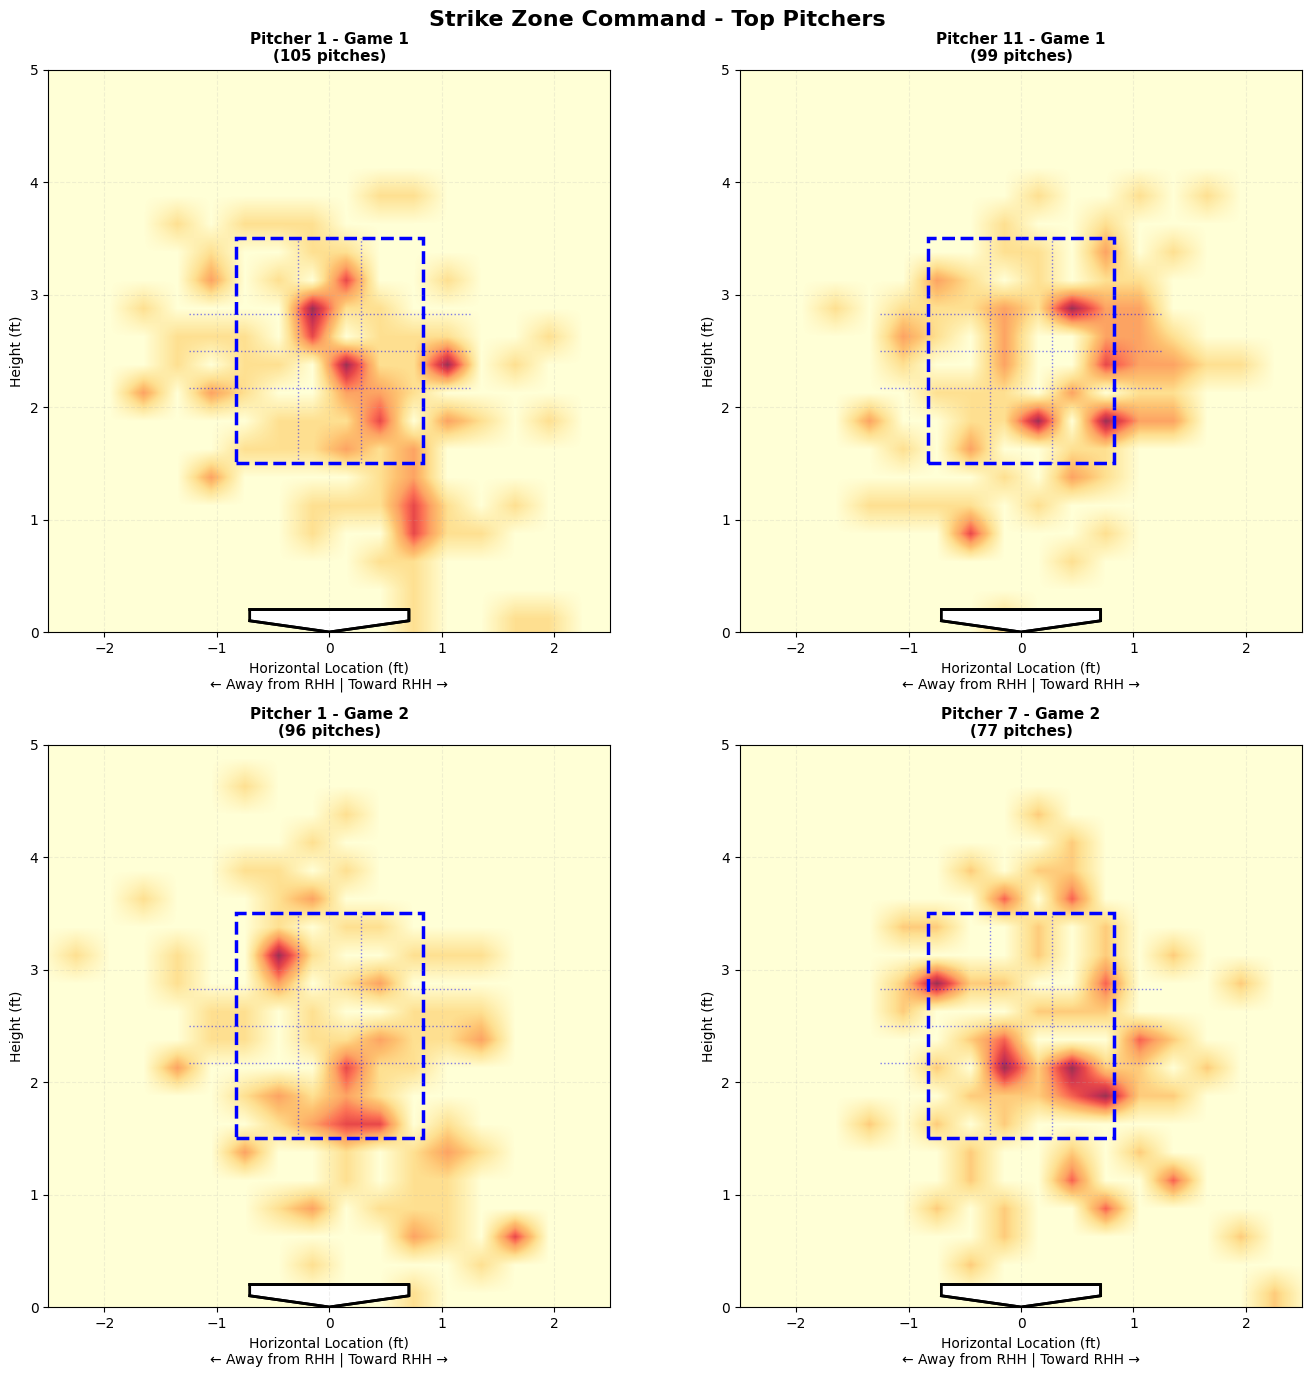

In [3]:
# Load data
df = pd.read_csv('AnalyticsQuestionnairePitchData.csv')
df.columns = df.columns.str.strip()

# Get top pitchers by pitch count from each game
pitcher_counts = df.groupby(['GamePk', 'PitcherId']).size().reset_index(name='Pitches')
pitcher_counts = pitcher_counts.sort_values(['GamePk', 'Pitches'], ascending=[True, False])

# Select top 2 from each game (4 total)
top_pitchers = []
for game in [1, 2]:
    game_pitchers = pitcher_counts[pitcher_counts['GamePk'] == game].head(2)
    top_pitchers.extend(game_pitchers.to_dict('records'))

# Create 2x2 grid of heat maps
fig, axes = plt.subplots(2, 2, figsize=(14, 14))
fig.suptitle('Strike Zone Command - Top Pitchers', fontsize=16, fontweight='bold')

axes = axes.flatten()

for idx, pitcher_info in enumerate(top_pitchers):
    ax = axes[idx]
    game = pitcher_info['GamePk']
    pitcher_id = pitcher_info['PitcherId']
    pitch_count = pitcher_info['Pitches']

    # Get pitcher's pitch location data
    pitcher_data = df[(df['GamePk'] == game) & (df['PitcherId'] == pitcher_id)]

    # Filter valid location data
    valid_locs = pitcher_data[
        (pitcher_data['TrajectoryLocationX'].notna()) &
        (pitcher_data['TrajectoryLocationZ'].notna())
    ]

    if len(valid_locs) > 5:  # Need minimum points for KDE
        x = valid_locs['TrajectoryLocationX'].values
        z = valid_locs['TrajectoryLocationZ'].values

        # Create 2D histogram / heat map
        heatmap, xedges, yedges = np.histogram2d(x, z, bins=20, range=[[-3, 3], [0, 5]])
        extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

        # Plot heat map
        im = ax.imshow(heatmap.T, extent=extent, origin='lower', cmap='YlOrRd',
                       aspect='auto', interpolation='bilinear', alpha=0.8)

        # Add strike zone box (approximate)
        strike_zone_width = 1.66  # feet (roughly 20 inches)
        strike_zone_bottom = 1.5  # feet
        strike_zone_top = 3.5     # feet

        zone = patches.Rectangle(
            (-strike_zone_width/2, strike_zone_bottom),
            strike_zone_width,
            strike_zone_top - strike_zone_bottom,
            linewidth=2.5,
            edgecolor='blue',
            facecolor='none',
            linestyle='--',
            label='Strike Zone'
        )
        ax.add_patch(zone)

        # Add middle lines to strike zone (divide into 9 zones)
        ax.axhline(2.5, xmin=0.25, xmax=0.75, color='blue', linestyle=':', alpha=0.5, linewidth=1)
        ax.axhline(2.17, xmin=0.25, xmax=0.75, color='blue', linestyle=':', alpha=0.5, linewidth=1)
        ax.axhline(2.83, xmin=0.25, xmax=0.75, color='blue', linestyle=':', alpha=0.5, linewidth=1)
        ax.axvline(-0.28, ymin=0.3, ymax=0.7, color='blue', linestyle=':', alpha=0.5, linewidth=1)
        ax.axvline(0.28, ymin=0.3, ymax=0.7, color='blue', linestyle=':', alpha=0.5, linewidth=1)

    else:
        # Not enough data, just scatter plot
        if len(valid_locs) > 0:
            ax.scatter(valid_locs['TrajectoryLocationX'],
                      valid_locs['TrajectoryLocationZ'],
                      alpha=0.5, s=30, c='red')

    # Formatting
    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(0, 5)
    ax.set_xlabel('Horizontal Location (ft)\n← Away from RHH | Toward RHH →', fontsize=10)
    ax.set_ylabel('Height (ft)', fontsize=10)
    ax.set_title(f"Pitcher {int(pitcher_id)} - Game {game}\n({pitch_count} pitches)",
                 fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.2, linestyle='--')
    ax.set_aspect('equal', adjustable='box')

    # Add home plate representation at bottom
    plate_x = [-0.708, 0.708, 0.708, 0, -0.708]
    plate_y = [0.2, 0.2, 0.1, 0, 0.1]
    ax.plot(plate_x, plate_y, 'k-', linewidth=2)
    ax.fill(plate_x, plate_y, color='white', edgecolor='black', linewidth=2)

plt.tight_layout()
plt.savefig('strike_zone_heatmaps.png', dpi=300, bbox_inches='tight')
print("Heat maps saved as 'strike_zone_heatmaps.png'")

# Print summary
print("\n" + "=" * 80)
print("STRIKE ZONE HEAT MAP SUMMARY")
print("=" * 80)
print("Showing pitch location patterns for top pitchers by workload")
print("\nPitchers analyzed:")
for i, p in enumerate(top_pitchers, 1):
    print(f"  {i}. Pitcher {int(p['PitcherId'])} (Game {p['GamePk']}): {p['Pitches']} pitches")
print("\nInterpretation:")
print("  - Warmer colors (red/orange) = higher pitch concentration")
print("  - Blue dashed box = approximate strike zone")
print("  - Catcher's perspective (RHH batter on right side of plate)")
print("=" * 80)

plt.show()

#  PITCHER EFFECTIVENESS METRICS COMPARISON
Purpose: Compare four key effectiveness metrics across all pitchers with 20+
         pitches to identify elite performers and weaknesses. Metrics capture
         command (Strike%), stuff (Whiff%), aggression (Zone%), and deception
         (Chase%).

Output: Figure 3 in the analysis document - "Pitcher Effectiveness Metrics Comparison"
        Exports 'effectiveness_comparison.png'

Key Metrics:
  - Strike%: Overall command and strike-throwing ability
  - Whiff%: Swing-and-miss capability (measures pitch quality)
  - Zone%: Aggression and willingness to challenge hitters
  - Chase%: Deception and ability to induce swings outside the zone

Key Features:
  - Grouped bar chart for direct metric comparison
  - Filtered to pitchers with 20+ pitches for statistical reliability
  - Separated by game with visual divider
  - Summary statistics highlighting top performers in each category#

Chart saved as 'effectiveness_comparison.png'

EFFECTIVENESS METRICS SUMMARY

Metric Definitions:
  Strike% = Called strikes + swinging strikes + fouls / Total pitches
  Whiff% = Swinging strikes / Total swings
  Zone% = Pitches in strike zone / Total pitches with location data
  Chase% = Swings at pitches outside zone / Pitches outside zone

----------------------------------------------------------------------------------------------------
  Pitcher  Game  PitcherId   Strike%    Whiff%     Zone%    Chase%
 P1\n(G1)     1          1 51.428571 22.222222 43.137255 39.655172
P11\n(G1)     1         11 44.444444 19.607843 46.391753 34.615385
 P5\n(G1)     1          5 37.931034 23.076923 65.384615 33.333333
P12\n(G1)     1         12 45.000000 36.363636 55.000000 22.222222
 P1\n(G2)     2          1 48.958333 29.411765 44.791667 35.849057
 P7\n(G2)     2          7 38.961039 26.829268 45.333333 31.707317
 P9\n(G2)     2          9 63.636364 36.363636 63.636364 25.000000
------------------

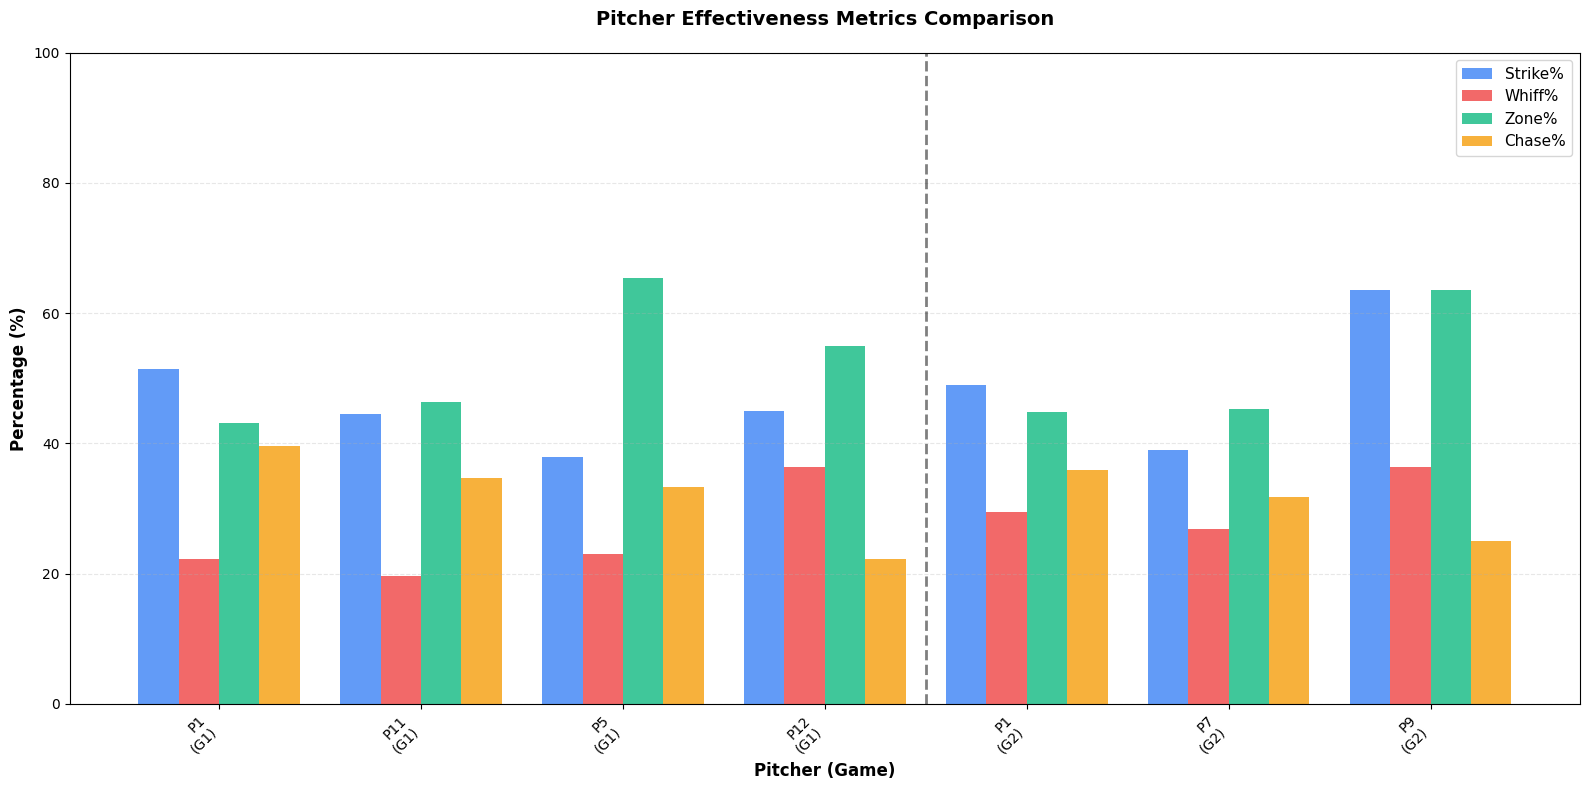

In [4]:
# Load data
df = pd.read_csv('AnalyticsQuestionnairePitchData.csv')
df.columns = df.columns.str.strip()

# Helper functions
def calculate_strike_rate(pitcher_data):
    strike_calls = ['called_strike', 'swinging_strike', 'foul', 'foul_tip',
                    'strikeout', 'foul_bunt', 'swinging_strike_blocked']
    strikes = pitcher_data[pitcher_data['PitchCall'].isin(strike_calls)].shape[0]
    return (strikes / len(pitcher_data) * 100) if len(pitcher_data) > 0 else 0

def calculate_whiff_rate(pitcher_data):
    swing_calls = ['swinging_strike', 'foul', 'foul_tip', 'strikeout',
                   'foul_bunt', 'swinging_strike_blocked', 'field_out',
                   'single', 'double', 'triple', 'home_run', 'field_error',
                   'sac_bunt', 'force_out', 'grounded_into_double_play']
    swings = pitcher_data[pitcher_data['PitchCall'].isin(swing_calls)].shape[0]

    whiff_calls = ['swinging_strike', 'strikeout', 'swinging_strike_blocked']
    whiffs = pitcher_data[pitcher_data['PitchCall'].isin(whiff_calls)].shape[0]

    return (whiffs / swings * 100) if swings > 0 else 0

def calculate_in_zone_rate(pitcher_data):
    # Approximate in-zone: -0.83 to 0.83 horizontal, 1.5 to 3.5 vertical
    in_zone = pitcher_data[
        (pitcher_data['TrajectoryLocationX'].between(-0.83, 0.83)) &
        (pitcher_data['TrajectoryLocationZ'].between(1.5, 3.5)) &
        (pitcher_data['TrajectoryLocationX'].notna()) &
        (pitcher_data['TrajectoryLocationZ'].notna())
    ].shape[0]

    valid_locs = pitcher_data[
        (pitcher_data['TrajectoryLocationX'].notna()) &
        (pitcher_data['TrajectoryLocationZ'].notna())
    ].shape[0]

    return (in_zone / valid_locs * 100) if valid_locs > 0 else 0

def calculate_chase_rate(pitcher_data):
    # Chase = swing at pitch outside zone
    out_zone_swings = pitcher_data[
        (
            (~pitcher_data['TrajectoryLocationX'].between(-0.83, 0.83)) |
            (~pitcher_data['TrajectoryLocationZ'].between(1.5, 3.5))
        ) &
        (pitcher_data['PitchCall'].isin(['swinging_strike', 'foul', 'foul_tip',
                                         'strikeout', 'foul_bunt', 'swinging_strike_blocked',
                                         'field_out', 'single', 'double', 'triple',
                                         'home_run', 'field_error', 'sac_bunt',
                                         'force_out', 'grounded_into_double_play'])) &
        (pitcher_data['TrajectoryLocationX'].notna()) &
        (pitcher_data['TrajectoryLocationZ'].notna())
    ].shape[0]

    out_zone_pitches = pitcher_data[
        (
            (~pitcher_data['TrajectoryLocationX'].between(-0.83, 0.83)) |
            (~pitcher_data['TrajectoryLocationZ'].between(1.5, 3.5))
        ) &
        (pitcher_data['TrajectoryLocationX'].notna()) &
        (pitcher_data['TrajectoryLocationZ'].notna())
    ].shape[0]

    return (out_zone_swings / out_zone_pitches * 100) if out_zone_pitches > 0 else 0

# Get top pitchers (20+ pitches)
pitcher_counts = df.groupby(['GamePk', 'PitcherId']).size().reset_index(name='Pitches')
top_pitchers = pitcher_counts[pitcher_counts['Pitches'] >= 20].sort_values(
    ['GamePk', 'Pitches'], ascending=[True, False]
)

# Calculate metrics for each pitcher
effectiveness_data = []

for _, row in top_pitchers.iterrows():
    game = row['GamePk']
    pitcher_id = row['PitcherId']

    pitcher_data = df[(df['GamePk'] == game) & (df['PitcherId'] == pitcher_id)]

    effectiveness_data.append({
        'Pitcher': f"P{int(pitcher_id)}\n(G{game})",
        'Game': game,
        'PitcherId': pitcher_id,
        'Strike%': calculate_strike_rate(pitcher_data),
        'Whiff%': calculate_whiff_rate(pitcher_data),
        'Zone%': calculate_in_zone_rate(pitcher_data),
        'Chase%': calculate_chase_rate(pitcher_data)
    })

effectiveness_df = pd.DataFrame(effectiveness_data)

# Create grouped bar chart
fig, ax = plt.subplots(figsize=(16, 8))

x = np.arange(len(effectiveness_df))
width = 0.2

metrics = ['Strike%', 'Whiff%', 'Zone%', 'Chase%']
colors = ['#3b82f6', '#ef4444', '#10b981', '#f59e0b']
positions = [-1.5*width, -0.5*width, 0.5*width, 1.5*width]

for metric, color, pos in zip(metrics, colors, positions):
    ax.bar(x + pos, effectiveness_df[metric], width, label=metric, color=color, alpha=0.8)

# Customize chart
ax.set_xlabel('Pitcher (Game)', fontsize=12, fontweight='bold')
ax.set_ylabel('Percentage (%)', fontsize=12, fontweight='bold')
ax.set_title('Pitcher Effectiveness Metrics Comparison', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(effectiveness_df['Pitcher'], rotation=45, ha='right')
ax.legend(loc='upper right', fontsize=11)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim(0, max(effectiveness_df[metrics].max().max() * 1.1, 100))

# Add separator between games
game1_count = len(effectiveness_df[effectiveness_df['Game'] == 1])
if 0 < game1_count < len(effectiveness_df):
    ax.axvline(x=game1_count - 0.5, color='black', linestyle='--', linewidth=2, alpha=0.5)

plt.tight_layout()
plt.savefig('effectiveness_comparison.png', dpi=300, bbox_inches='tight')
print("Chart saved as 'effectiveness_comparison.png'")

# Print summary stats
print("\n" + "=" * 100)
print("EFFECTIVENESS METRICS SUMMARY")
print("=" * 100)
print("\nMetric Definitions:")
print("  Strike% = Called strikes + swinging strikes + fouls / Total pitches")
print("  Whiff% = Swinging strikes / Total swings")
print("  Zone% = Pitches in strike zone / Total pitches with location data")
print("  Chase% = Swings at pitches outside zone / Pitches outside zone")
print("\n" + "-" * 100)
print(effectiveness_df.to_string(index=False))
print("-" * 100)

# Highlight top performers
print("\nTop Performers:")
print(f"  Highest Strike%: Pitcher {int(effectiveness_df.loc[effectiveness_df['Strike%'].idxmax(), 'PitcherId'])} - {effectiveness_df['Strike%'].max():.1f}%")
print(f"  Highest Whiff%: Pitcher {int(effectiveness_df.loc[effectiveness_df['Whiff%'].idxmax(), 'PitcherId'])} - {effectiveness_df['Whiff%'].max():.1f}%")
print(f"  Highest Zone%: Pitcher {int(effectiveness_df.loc[effectiveness_df['Zone%'].idxmax(), 'PitcherId'])} - {effectiveness_df['Zone%'].max():.1f}%")
print(f"  Highest Chase%: Pitcher {int(effectiveness_df.loc[effectiveness_df['Chase%'].idxmax(), 'PitcherId'])} - {effectiveness_df['Chase%'].max():.1f}%")
print("=" * 100)

plt.show()

# GAME-LEVEL PERFORMANCE COMPARISON
Purpose: Aggregate and compare pitching performance metrics between Game 1 and
         Game 2 to identify which game featured superior overall effectiveness,
         stuff quality, and strategic approaches.

Output: Table 1 in the analysis document - "Game-Level Comparison"
        Exports 'game_comparison_table.csv'

Key Metrics Compared:
  - Workload: Total pitches, unique pitchers
  - Effectiveness: Strike%, Ball%, Swing%, Whiff%, Contact%
  - Results: Balls in play
  - Stuff Quality: Average/Max velocity, average spin rate
  - Strategy: Most frequently used pitch type

Key Features:
  - Side-by-side comparison of both games
  - Automated insights highlighting performance differences
  - Comprehensive summary of aggregate pitching performance

In [5]:
# Load data
df = pd.read_csv('AnalyticsQuestionnairePitchData.csv')
df.columns = df.columns.str.strip()

# Helper functions
def calculate_metrics_for_game(game_data):
    total_pitches = len(game_data)

    # Strike rate
    strike_calls = ['called_strike', 'swinging_strike', 'foul', 'foul_tip',
                    'strikeout', 'foul_bunt', 'swinging_strike_blocked']
    strikes = game_data[game_data['PitchCall'].isin(strike_calls)].shape[0]
    strike_rate = (strikes / total_pitches * 100) if total_pitches > 0 else 0

    # Ball rate
    ball_calls = ['ball', 'blocked_ball', 'walk', 'wild_pitch']
    balls = game_data[game_data['PitchCall'].isin(ball_calls)].shape[0]
    ball_rate = (balls / total_pitches * 100) if total_pitches > 0 else 0

    # Swing rate
    swing_calls = ['swinging_strike', 'foul', 'foul_tip', 'strikeout',
                   'foul_bunt', 'swinging_strike_blocked', 'field_out',
                   'single', 'double', 'triple', 'home_run', 'field_error',
                   'sac_bunt', 'force_out', 'grounded_into_double_play']
    swings = game_data[game_data['PitchCall'].isin(swing_calls)].shape[0]
    swing_rate = (swings / total_pitches * 100) if total_pitches > 0 else 0

    # Whiff rate
    whiff_calls = ['swinging_strike', 'strikeout', 'swinging_strike_blocked']
    whiffs = game_data[game_data['PitchCall'].isin(whiff_calls)].shape[0]
    whiff_rate = (whiffs / swings * 100) if swings > 0 else 0

    # Contact rate
    contact_calls = ['foul', 'foul_tip', 'foul_bunt', 'field_out',
                     'single', 'double', 'triple', 'home_run', 'field_error',
                     'sac_bunt', 'force_out', 'grounded_into_double_play']
    contact = game_data[game_data['PitchCall'].isin(contact_calls)].shape[0]
    contact_rate = (contact / swings * 100) if swings > 0 else 0

    # Balls in play
    in_play_calls = ['field_out', 'single', 'double', 'triple', 'home_run',
                     'field_error', 'sac_bunt', 'force_out', 'grounded_into_double_play']
    balls_in_play = game_data[game_data['PitchCall'].isin(in_play_calls)].shape[0]

    # Velocity stats
    avg_velo = game_data['ReleaseSpeed'].mean()
    max_velo = game_data['ReleaseSpeed'].max()

    # Spin rate stats
    avg_spin = game_data['ReleaseSpinRate'].mean()

    # Pitch type distribution
    pitch_counts = game_data['PitchType'].value_counts()
    most_common = pitch_counts.index[0] if len(pitch_counts) > 0 else 'N/A'
    most_common_pct = (pitch_counts.iloc[0] / total_pitches * 100) if len(pitch_counts) > 0 else 0

    # Unique pitchers
    unique_pitchers = game_data['PitcherId'].nunique()

    return {
        'Total Pitches': total_pitches,
        'Unique Pitchers': unique_pitchers,
        'Strike Rate': f"{strike_rate:.1f}%",
        'Ball Rate': f"{ball_rate:.1f}%",
        'Swing Rate': f"{swing_rate:.1f}%",
        'Whiff Rate': f"{whiff_rate:.1f}%",
        'Contact Rate': f"{contact_rate:.1f}%",
        'Balls in Play': balls_in_play,
        'Avg Velocity': f"{avg_velo:.1f} mph" if not np.isnan(avg_velo) else 'N/A',
        'Max Velocity': f"{max_velo:.1f} mph" if not np.isnan(max_velo) else 'N/A',
        'Avg Spin Rate': f"{avg_spin:.0f} rpm" if not np.isnan(avg_spin) else 'N/A',
        'Most Used Pitch': f"{most_common} ({most_common_pct:.1f}%)"
    }

# Calculate metrics for each game
game1_data = df[df['GamePk'] == 1]
game2_data = df[df['GamePk'] == 2]

game1_metrics = calculate_metrics_for_game(game1_data)
game2_metrics = calculate_metrics_for_game(game2_data)

# Create comparison table
comparison_data = {
    'Metric': list(game1_metrics.keys()),
    'Game 1': list(game1_metrics.values()),
    'Game 2': list(game2_metrics.values())
}

comparison_df = pd.DataFrame(comparison_data)

# Display the table
print("=" * 100)
print("GAME-LEVEL PERFORMANCE COMPARISON")
print("=" * 100)
print(comparison_df.to_string(index=False))
print("=" * 100)

# Add key insights
print("\nKEY INSIGHTS:")

# Compare strike rates
g1_strike = float(game1_metrics['Strike Rate'].rstrip('%'))
g2_strike = float(game2_metrics['Strike Rate'].rstrip('%'))
if g2_strike > g1_strike:
    print(f"  • Game 2 had better strike rate (+{g2_strike - g1_strike:.1f}%)")
else:
    print(f"  • Game 1 had better strike rate (+{g1_strike - g2_strike:.1f}%)")

# Compare whiff rates
g1_whiff = float(game1_metrics['Whiff Rate'].rstrip('%'))
g2_whiff = float(game2_metrics['Whiff Rate'].rstrip('%'))
if g2_whiff > g1_whiff:
    print(f"  • Game 2 generated more swings and misses (+{g2_whiff - g1_whiff:.1f}%)")
else:
    print(f"  • Game 1 generated more swings and misses (+{g1_whiff - g2_whiff:.1f}%)")

# Compare velocity
g1_velo = float(game1_metrics['Avg Velocity'].split()[0])
g2_velo = float(game2_metrics['Avg Velocity'].split()[0])
if g2_velo > g1_velo:
    print(f"  • Game 2 averaged higher velocity (+{g2_velo - g1_velo:.1f} mph)")
else:
    print(f"  • Game 1 averaged higher velocity (+{g1_velo - g2_velo:.1f} mph)")

# Compare balls in play
if game2_metrics['Balls in Play'] < game1_metrics['Balls in Play']:
    print(f"  • Game 2 limited balls in play more effectively ({game2_metrics['Balls in Play']} vs {game1_metrics['Balls in Play']})")
else:
    print(f"  • Game 1 limited balls in play more effectively ({game1_metrics['Balls in Play']} vs {game2_metrics['Balls in Play']})")

print("=" * 100)

# Save to CSV
comparison_df.to_csv('game_comparison_table.csv', index=False)
print("\nTable saved to 'game_comparison_table.csv'")

GAME-LEVEL PERFORMANCE COMPARISON
         Metric     Game 1     Game 2
  Total Pitches        361        259
Unique Pitchers         12          8
    Strike Rate      43.2%      44.4%
      Ball Rate      34.3%      35.5%
     Swing Rate      47.6%      49.4%
     Whiff Rate      22.7%      28.9%
   Contact Rate      77.3%      71.1%
  Balls in Play         62         49
   Avg Velocity   89.8 mph   90.3 mph
   Max Velocity  101.6 mph   98.8 mph
  Avg Spin Rate   2313 rpm   2347 rpm
Most Used Pitch FF (28.5%) FF (40.5%)

KEY INSIGHTS:
  • Game 2 had better strike rate (+1.2%)
  • Game 2 generated more swings and misses (+6.2%)
  • Game 2 averaged higher velocity (+0.5 mph)
  • Game 2 limited balls in play more effectively (49 vs 62)

Table saved to 'game_comparison_table.csv'


# PITCHER STUFF QUALITY EVALUATION (VELOCITY VS SPIN RATE)
Purpose: Visualize the relationship between velocity and spin rate to identify
         pitchers with elite raw stuff versus those who rely on command and
         deception. Bubble size represents workload (pitch count).

Output: Figure 4 in the analysis document - "Pitcher Stuff Quality: Velocity vs Spin Rate"
        Exports 'velocity_spin_scatter.png'

Key Features:
  - Scatter plot with velocity (x-axis) vs spin rate (y-axis)
  - Bubble size proportional to pitch count (larger = more pitches)
  - Color-coded by game (blue = Game 1, red = Game 2)
  - Quadrant analysis with reference lines at overall averages
  - Elite stuff (upper-right), Power arms, Spin masters, Crafty (lower-left)
  
Interpretation:
  - Upper-right quadrant = Elite stuff (high velocity + high spin)
  - Lower-left quadrant = Crafty/Finesse pitchers (rely on command/deception)
  - Filters to pitchers with 15+ pitches for statistical reliability

Scatter plot saved as 'velocity_spin_scatter.png'

VELOCITY VS SPIN RATE ANALYSIS

Overall Averages:
  Average Velocity: 90.9 mph
  Average Spin Rate: 2313 rpm

Quadrant Breakdown:

Elite Stuff (Above avg in both):
  Pitcher 13.0 (Game 1.0): 91.7 mph, 2402 rpm
  Pitcher 14.0 (Game 1.0): 91.5 mph, 2331 rpm
  Pitcher 3.0 (Game 1.0): 92.9 mph, 2458 rpm
  Pitcher 17.0 (Game 2.0): 92.1 mph, 2381 rpm

Power Arms (High velo, avg/lower spin):
  Pitcher 12.0 (Game 1.0): 93.2 mph, 2030 rpm
  Pitcher 15.0 (Game 2.0): 92.9 mph, 2183 rpm

Spin Masters (High spin, avg/lower velo):
  Pitcher 5.0 (Game 1.0): 88.5 mph, 2504 rpm
  Pitcher 7.0 (Game 2.0): 89.3 mph, 2517 rpm
  Pitcher 9.0 (Game 2.0): 90.7 mph, 2420 rpm

Crafty/Finesse (Below avg in both):
  Pitcher 11.0 (Game 1.0): 88.5 mph, 2295 rpm
  Pitcher 1.0 (Game 1.0): 89.1 mph, 2275 rpm
  Pitcher 1.0 (Game 2.0): 89.9 mph, 2277 rpm
  Pitcher 10.0 (Game 2.0): 90.9 mph, 1992 rpm


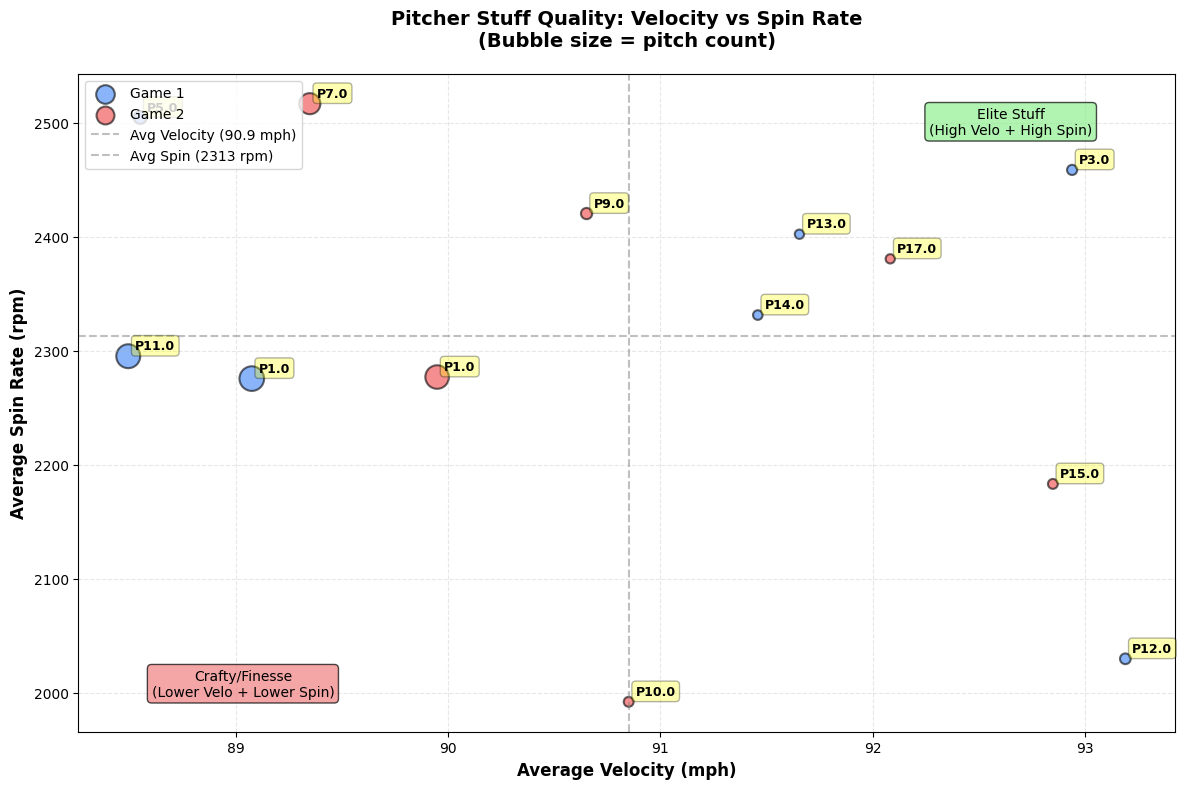

In [6]:
# Load data
df = pd.read_csv('AnalyticsQuestionnairePitchData.csv')
df.columns = df.columns.str.strip()

# Calculate pitcher-level velocity and spin
pitcher_stats = []

for game in [1, 2]:
    game_data = df[df['GamePk'] == game]

    for pitcher_id in game_data['PitcherId'].unique():
        pitcher_data = game_data[game_data['PitcherId'] == pitcher_id]

        total_pitches = len(pitcher_data)

        # Only include pitchers with 15+ pitches for meaningful averages
        if total_pitches >= 15:
            avg_velo = pitcher_data['ReleaseSpeed'].mean()
            avg_spin = pitcher_data['ReleaseSpinRate'].mean()

            # Skip if missing data
            if pd.notna(avg_velo) and pd.notna(avg_spin):
                pitcher_stats.append({
                    'PitcherId': int(pitcher_id),
                    'Game': game,
                    'Pitches': total_pitches,
                    'AvgVelo': avg_velo,
                    'AvgSpin': avg_spin
                })

pitcher_df = pd.DataFrame(pitcher_stats)

# Create scatter plot
fig, ax = plt.subplots(figsize=(12, 8))

# Separate by game for different colors
game1 = pitcher_df[pitcher_df['Game'] == 1]
game2 = pitcher_df[pitcher_df['Game'] == 2]

# Plot Game 1 pitchers
scatter1 = ax.scatter(game1['AvgVelo'], game1['AvgSpin'],
                      s=game1['Pitches']*3, alpha=0.6, c='#3b82f6',
                      edgecolors='black', linewidth=1.5, label='Game 1')

# Plot Game 2 pitchers
scatter2 = ax.scatter(game2['AvgVelo'], game2['AvgSpin'],
                      s=game2['Pitches']*3, alpha=0.6, c='#ef4444',
                      edgecolors='black', linewidth=1.5, label='Game 2')

# Add labels for each pitcher
for _, row in pitcher_df.iterrows():
    ax.annotate(f"P{row['PitcherId']}",
                (row['AvgVelo'], row['AvgSpin']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=9, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3))

# Add reference lines for average
avg_velo_all = pitcher_df['AvgVelo'].mean()
avg_spin_all = pitcher_df['AvgSpin'].mean()

ax.axvline(avg_velo_all, color='gray', linestyle='--', linewidth=1.5, alpha=0.5, label=f'Avg Velocity ({avg_velo_all:.1f} mph)')
ax.axhline(avg_spin_all, color='gray', linestyle='--', linewidth=1.5, alpha=0.5, label=f'Avg Spin ({avg_spin_all:.0f} rpm)')

# Add quadrant labels
x_range = ax.get_xlim()
y_range = ax.get_ylim()
offset = 0.02

# Top-right quadrant (elite stuff)
ax.text(x_range[1] - (x_range[1]-x_range[0])*0.15,
        y_range[1] - (y_range[1]-y_range[0])*0.05,
        'Elite Stuff\n(High Velo + High Spin)',
        fontsize=10, ha='center', va='top',
        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))

# Bottom-left quadrant (crafty)
ax.text(x_range[0] + (x_range[1]-x_range[0])*0.15,
        y_range[0] + (y_range[1]-y_range[0])*0.05,
        'Crafty/Finesse\n(Lower Velo + Lower Spin)',
        fontsize=10, ha='center', va='bottom',
        bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))

# Customize chart
ax.set_xlabel('Average Velocity (mph)', fontsize=12, fontweight='bold')
ax.set_ylabel('Average Spin Rate (rpm)', fontsize=12, fontweight='bold')
ax.set_title('Pitcher Stuff Quality: Velocity vs Spin Rate\n(Bubble size = pitch count)',
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('velocity_spin_scatter.png', dpi=300, bbox_inches='tight')
print("Scatter plot saved as 'velocity_spin_scatter.png'")

# Print analysis
print("\n" + "=" * 100)
print("VELOCITY VS SPIN RATE ANALYSIS")
print("=" * 100)
print(f"\nOverall Averages:")
print(f"  Average Velocity: {avg_velo_all:.1f} mph")
print(f"  Average Spin Rate: {avg_spin_all:.0f} rpm")

print("\nQuadrant Breakdown:")

# Elite stuff (top-right)
elite = pitcher_df[(pitcher_df['AvgVelo'] > avg_velo_all) & (pitcher_df['AvgSpin'] > avg_spin_all)]
print(f"\nElite Stuff (Above avg in both):")
if len(elite) > 0:
    for _, p in elite.iterrows():
        print(f"  Pitcher {p['PitcherId']} (Game {p['Game']}): {p['AvgVelo']:.1f} mph, {p['AvgSpin']:.0f} rpm")
else:
    print("  None")

# Power arms (high velo, lower spin)
power = pitcher_df[(pitcher_df['AvgVelo'] > avg_velo_all) & (pitcher_df['AvgSpin'] <= avg_spin_all)]
print(f"\nPower Arms (High velo, avg/lower spin):")
if len(power) > 0:
    for _, p in power.iterrows():
        print(f"  Pitcher {p['PitcherId']} (Game {p['Game']}): {p['AvgVelo']:.1f} mph, {p['AvgSpin']:.0f} rpm")
else:
    print("  None")

# Spin masters (high spin, lower velo)
spin_masters = pitcher_df[(pitcher_df['AvgVelo'] <= avg_velo_all) & (pitcher_df['AvgSpin'] > avg_spin_all)]
print(f"\nSpin Masters (High spin, avg/lower velo):")
if len(spin_masters) > 0:
    for _, p in spin_masters.iterrows():
        print(f"  Pitcher {p['PitcherId']} (Game {p['Game']}): {p['AvgVelo']:.1f} mph, {p['AvgSpin']:.0f} rpm")
else:
    print("  None")

# Crafty (both below average)
crafty = pitcher_df[(pitcher_df['AvgVelo'] <= avg_velo_all) & (pitcher_df['AvgSpin'] <= avg_spin_all)]
print(f"\nCrafty/Finesse (Below avg in both):")
if len(crafty) > 0:
    for _, p in crafty.iterrows():
        print(f"  Pitcher {p['PitcherId']} (Game {p['Game']}): {p['AvgVelo']:.1f} mph, {p['AvgSpin']:.0f} rpm")
else:
    print("  None")

print("=" * 100)

plt.show()

# PITCH TYPE EFFECTIVENESS - ARSENAL BREAKDOWN
Purpose: Provide granular, pitch-by-pitch breakdown for each pitcher showing
         how individual pitch types performed. Identifies which pitches serve
         as primary weapons versus those needing development attention.

Output: Table 3 in the analysis document - "Arsenal Breakdown - Pitch Type Effectiveness"
        Exports 'pitch_type_effectiveness_table.png' and
        'pitch_type_effectiveness_detail.csv'

Key Metrics by Pitch Type:
  - Count: Number of times pitch was thrown
  - Usage%: Percentage of pitcher's total arsenal
  - Avg Velo: Average velocity for this specific pitch
  - Avg Spin: Average spin rate for this specific pitch
  - Strike%: Strike rate for this pitch only
  - Whiff%: Whiff rate for this pitch only
  - In Play: Number of balls put in play

Key Features:
  - Filtered to pitchers with 30+ total pitches
  - Each pitch type requires 3+ throws to be included
  - Grouped and color-coded by pitcher for easy scanning
  - Summary statistics highlighting elite pitch performances
  - Reveals which offerings are effective vs. which need refinement

Pitch type effectiveness table saved as 'pitch_type_effectiveness_table.png'
Detailed data saved to 'pitch_type_effectiveness_detail.csv'

PITCH TYPE EFFECTIVENESS SUMMARY

Highest Whiff Rate: P1 (G1) - SL at 62.5%
Hardest Pitch: P1 (G1) - FF at 95.1 mph
Best Strike Rate: P1 (G2) - CU at 66.7%


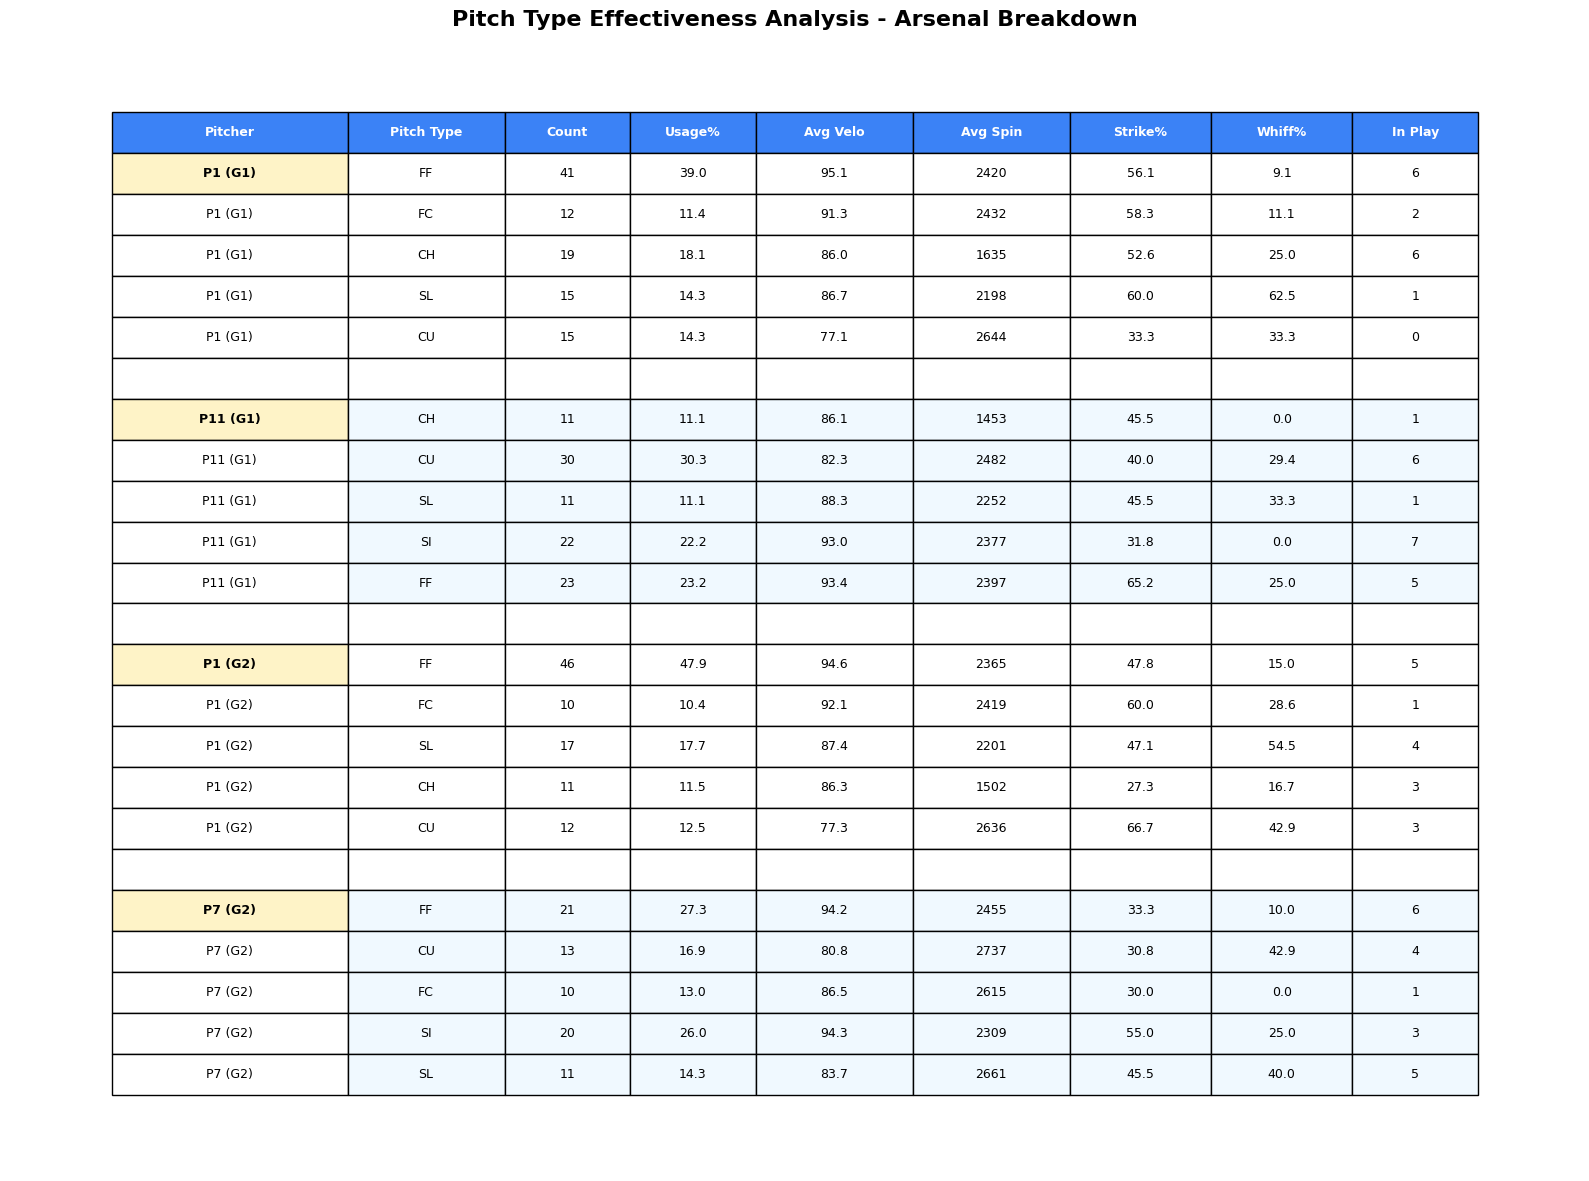

In [8]:
# Load data
df = pd.read_csv('AnalyticsQuestionnairePitchData.csv')
df.columns = df.columns.str.strip()

# Helper functions
def calculate_strike_rate(pitch_data):
    strike_calls = ['called_strike', 'swinging_strike', 'foul', 'foul_tip',
                    'strikeout', 'foul_bunt', 'swinging_strike_blocked']
    strikes = pitch_data[pitch_data['PitchCall'].isin(strike_calls)].shape[0]
    return (strikes / len(pitch_data) * 100) if len(pitch_data) > 0 else 0

def calculate_whiff_rate(pitch_data):
    swing_calls = ['swinging_strike', 'foul', 'foul_tip', 'strikeout',
                   'foul_bunt', 'swinging_strike_blocked', 'field_out',
                   'single', 'double', 'triple', 'home_run', 'field_error',
                   'sac_bunt', 'force_out', 'grounded_into_double_play']
    swings = pitch_data[pitch_data['PitchCall'].isin(swing_calls)].shape[0]

    whiff_calls = ['swinging_strike', 'strikeout', 'swinging_strike_blocked']
    whiffs = pitch_data[pitch_data['PitchCall'].isin(whiff_calls)].shape[0]

    return (whiffs / swings * 100) if swings > 0 else 0

def calculate_in_play(pitch_data):
    in_play_calls = ['field_out', 'single', 'double', 'triple', 'home_run',
                     'field_error', 'sac_bunt', 'force_out', 'grounded_into_double_play']
    return pitch_data[pitch_data['PitchCall'].isin(in_play_calls)].shape[0]

# Get top pitchers (at least 30 pitches)
pitcher_counts = df.groupby(['GamePk', 'PitcherId']).size().reset_index(name='TotalPitches')
top_pitchers = pitcher_counts[pitcher_counts['TotalPitches'] >= 30].sort_values(
    ['GamePk', 'TotalPitches'], ascending=[True, False]
)

# Collect all pitch type data
all_pitcher_arsenal_data = []

for idx, row in top_pitchers.iterrows():
    game = row['GamePk']
    pitcher_id = row['PitcherId']
    total_pitches = row['TotalPitches']

    pitcher_data = df[(df['GamePk'] == game) & (df['PitcherId'] == pitcher_id)]

    for pitch_type in pitcher_data['PitchType'].unique():
        if pd.notna(pitch_type) and pitch_type != 'NULL':
            pitch_type_data = pitcher_data[pitcher_data['PitchType'] == pitch_type]

            count = len(pitch_type_data)

            if count >= 3:  # At least 3 pitches
                usage_pct = (count / total_pitches * 100)
                avg_velo = pitch_type_data['ReleaseSpeed'].mean()
                avg_spin = pitch_type_data['ReleaseSpinRate'].mean()
                strike_rate = calculate_strike_rate(pitch_type_data)
                whiff_rate = calculate_whiff_rate(pitch_type_data)
                in_play = calculate_in_play(pitch_type_data)

                all_pitcher_arsenal_data.append({
                    'Pitcher': f"P{int(pitcher_id)} (G{game})",
                    'Pitch Type': pitch_type,
                    'Count': count,
                    'Usage%': f"{usage_pct:.1f}",
                    'Avg Velo': f"{avg_velo:.1f}" if not np.isnan(avg_velo) else 'N/A',
                    'Avg Spin': f"{avg_spin:.0f}" if not np.isnan(avg_spin) else 'N/A',
                    'Strike%': f"{strike_rate:.1f}",
                    'Whiff%': f"{whiff_rate:.1f}",
                    'In Play': in_play
                })

# Create DataFrame
arsenal_df = pd.DataFrame(all_pitcher_arsenal_data)

# Create figure with table
fig, ax = plt.subplots(figsize=(16, 12))
ax.axis('tight')
ax.axis('off')

# Add title
fig.suptitle('Pitch Type Effectiveness Analysis - Arsenal Breakdown',
             fontsize=16, fontweight='bold', y=0.98)

# Create table
table_data = []
headers = ['Pitcher', 'Pitch Type', 'Count', 'Usage%', 'Avg Velo', 'Avg Spin', 'Strike%', 'Whiff%', 'In Play']

# Add rows grouped by pitcher
current_pitcher = None
for _, row in arsenal_df.iterrows():
    if current_pitcher != row['Pitcher']:
        # Add separator row
        if current_pitcher is not None:
            table_data.append([''] * len(headers))
        current_pitcher = row['Pitcher']

    table_data.append([
        row['Pitcher'],
        row['Pitch Type'],
        row['Count'],
        row['Usage%'],
        row['Avg Velo'],
        row['Avg Spin'],
        row['Strike%'],
        row['Whiff%'],
        row['In Play']
    ])

# Create the table
table = ax.table(cellText=table_data, colLabels=headers, cellLoc='center', loc='center',
                colWidths=[0.15, 0.1, 0.08, 0.08, 0.1, 0.1, 0.09, 0.09, 0.08])

table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)

# Style the header
for i in range(len(headers)):
    table[(0, i)].set_facecolor('#3b82f6')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Style the rows - alternate colors and highlight pitcher names
current_pitcher = None
color_toggle = True

for i, row_data in enumerate(table_data, 1):
    if row_data[0] != '':  # Not a separator
        if current_pitcher != row_data[0]:
            current_pitcher = row_data[0]
            color_toggle = not color_toggle
            # Highlight pitcher name
            table[(i, 0)].set_facecolor('#fef3c7')
            table[(i, 0)].set_text_props(weight='bold')

        row_color = '#f0f9ff' if color_toggle else '#ffffff'
        for j in range(len(headers)):
            if j > 0:  # Don't recolor the pitcher name column
                table[(i, j)].set_facecolor(row_color)

plt.tight_layout()
plt.savefig('pitch_type_effectiveness_table.png', dpi=300, bbox_inches='tight')
print("Pitch type effectiveness table saved as 'pitch_type_effectiveness_table.png'")

# Also save as CSV for easy reference
arsenal_df.to_csv('pitch_type_effectiveness_detail.csv', index=False)
print("Detailed data saved to 'pitch_type_effectiveness_detail.csv'")

# Print summary statistics
print("\n" + "=" * 100)
print("PITCH TYPE EFFECTIVENESS SUMMARY")
print("=" * 100)

# Best pitch by whiff rate
arsenal_df['WhiffNum'] = arsenal_df['Whiff%'].astype(float)
best_whiff = arsenal_df.loc[arsenal_df['WhiffNum'].idxmax()]
print(f"\nHighest Whiff Rate: {best_whiff['Pitcher']} - {best_whiff['Pitch Type']} at {best_whiff['Whiff%']}%")

# Hardest pitch
arsenal_df_velo = arsenal_df[arsenal_df['Avg Velo'] != 'N/A'].copy()
arsenal_df_velo['VeloNum'] = arsenal_df_velo['Avg Velo'].astype(float)
hardest = arsenal_df_velo.loc[arsenal_df_velo['VeloNum'].idxmax()]
print(f"Hardest Pitch: {hardest['Pitcher']} - {hardest['Pitch Type']} at {hardest['Avg Velo']} mph")

# Best strike rate
arsenal_df['StrikeNum'] = arsenal_df['Strike%'].astype(float)
best_strike = arsenal_df.loc[arsenal_df['StrikeNum'].idxmax()]
print(f"Best Strike Rate: {best_strike['Pitcher']} - {best_strike['Pitch Type']} at {best_strike['Strike%']}%")

print("=" * 100)

plt.show()